In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format

from model_SARIMA import build_SARIMA, optimal_orders_5, optimal_orders_10
from model_naiv import build_naive_model
from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import *
from test_normal import hist_plot
from time_series import *
from cross_validation import *


warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [3]:
# Filtern nach Store
store_number = 1
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

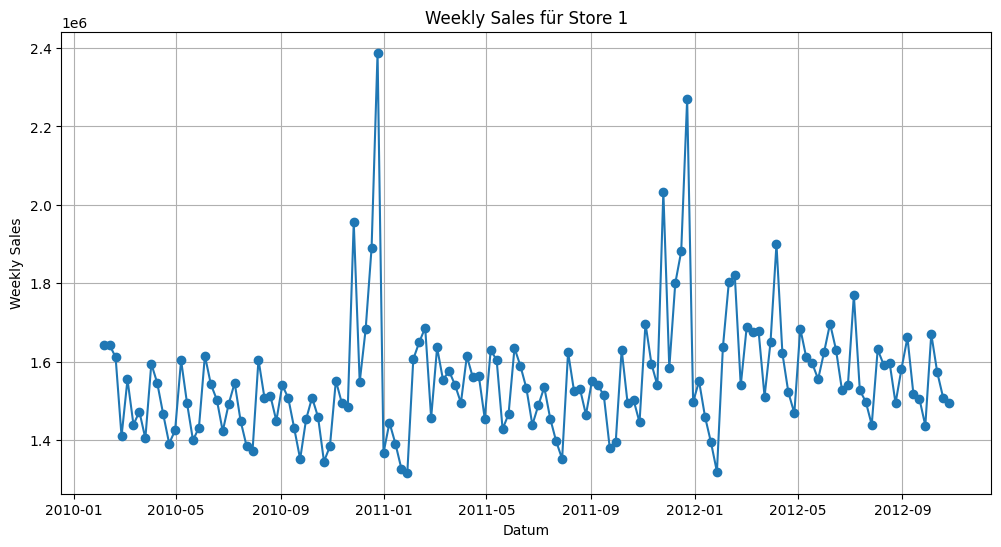

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Seasonal

In [5]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

SARIMA Modell

In [6]:
sarima_params  = optimal_orders_5.get(str(store_number))

order = tuple(sarima_params["order"])
seasonal_order = tuple(sarima_params["seasonal_order"])

sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
sarima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        weekly_sales   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 52)   Log Likelihood               -1884.296
Date:                             Tue, 08 Apr 2025   AIC                           3776.592
Time:                                     18:02:09   BIC                           3788.415
Sample:                                 02-05-2010   HQIC                          3781.396
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4168      0.091      4.596      0.000       0.239       0.594
ma.L1         -0.8985      0.048    -18.584      0.000      -0.993      -0.804
ar.S.L52       0.4936      0.038     12.973      0.000       0.419       0.568
sigma2      2.445e+10   3.87e-13   6.32e+22      0.000    2.44e+10    2.44e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.44   Jarque-Bera (JB):               155.95
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.48e+41. Standard errors may be unstable.
"""

Naives Modell

In [7]:
naiv_resid, naiv_fitted = build_naive_model(sales)

Modell wählen

In [ ]:
#residuen = naiv_resid
#fitted_values = naiv_fitted

resid = sarima_model.resid.iloc[1:]
fitted_values = sarima_model.fittedvalues.iloc[1:]

relative_resid = resid / sales.iloc[1:]

plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.title('SARIMA: Beobachtete Werte vs. Fitted values für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()

Korrelation Tests

Box Pierce Test
p-Wert an lag 29: 0.0000
p-Wert Median: 7.103900269249428e-20

Ljung Box Test
p-Wert an lag 29: 0.0000
p-Wert Median: 2.091861013804171e-21

Breusch Godfrey: 0.9992
Monti Test: 0.0000
Fisher Test: 0.0000
Run Test: 0.0000
Durbin Watson: 2.7424


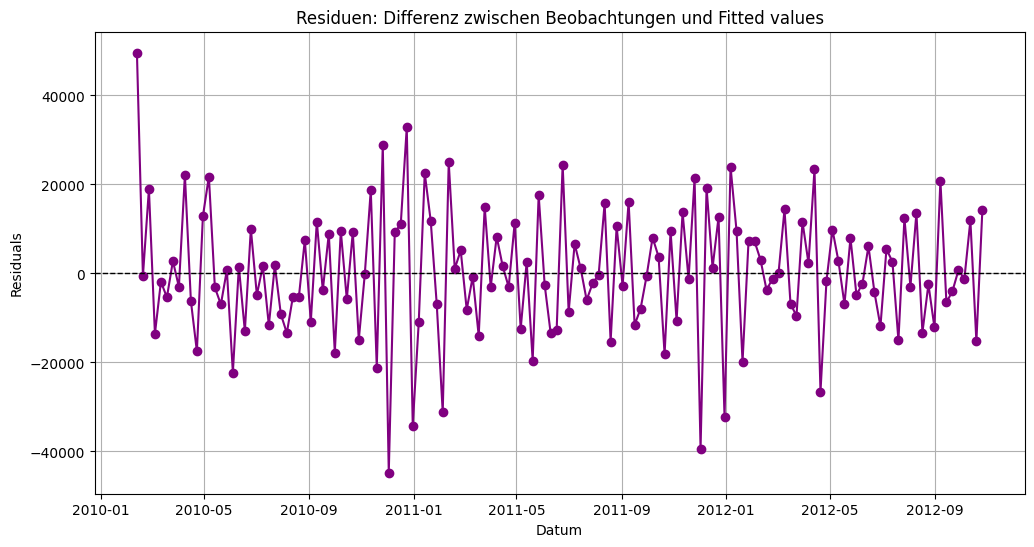

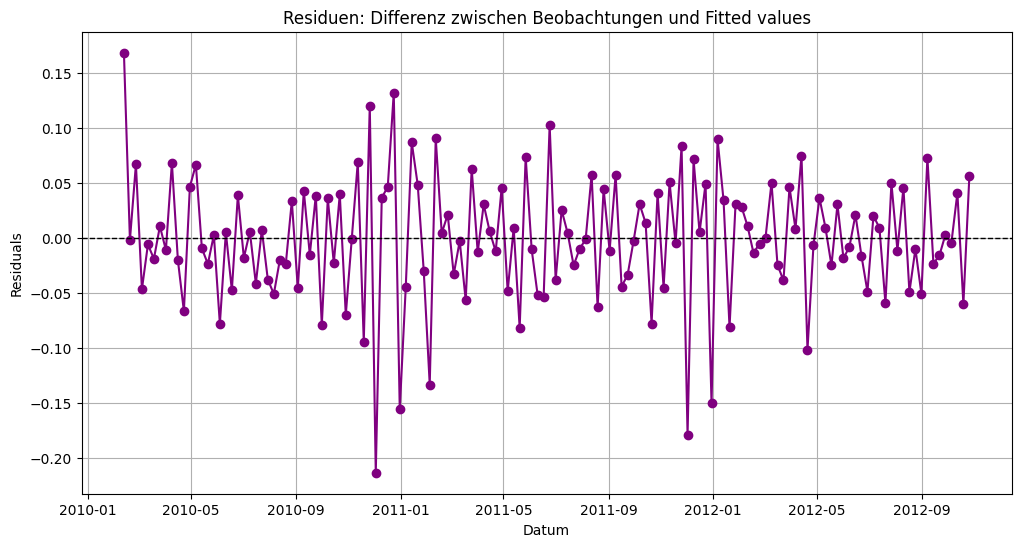

<Figure size 1200x600 with 0 Axes>

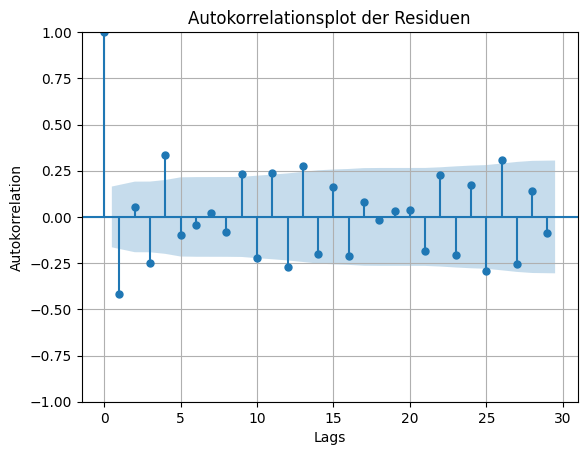

In [ ]:
box_pierce_test(residuals = resid, store_num = store_number, lags = 29)
ljung_box_test(residuals = resid, store_num = store_number, lags = 29)
breusch_godfrey_test(model = sarima_model, lags = 29)
monti_test(residuals = resid, store_num = store_number, m = 29)
fisher_test(residuals = resid, store_num = store_number, m = 4)
run_test(residuals = resid)

durbin_watson_test(residuals = resid)

residual_plot(resid)
residual_plot(relative_resid)

acf_resid_plot(resid, lags = 29)


Mittelwert Tests

Mittelwert der Residuen: 174.8534
Mittelwert der relativen Residuen: -0.0013
T-Test: 0.8848
Wilcoxon Test: 0.8955
Binomial Test: 0.6749
Kolmogorov Test: 0.7745


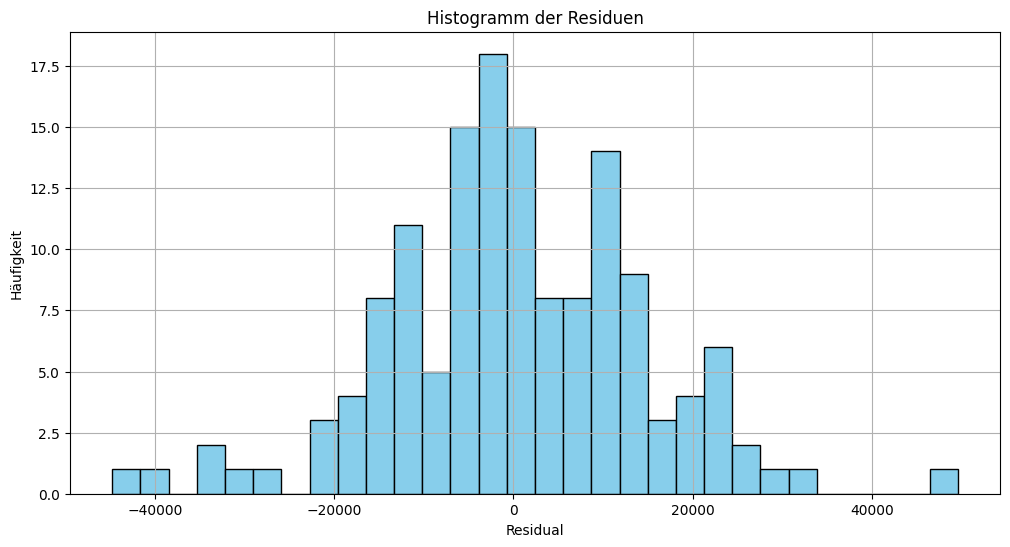

In [ ]:
print(f"Mittelwert der Residuen: {resid.mean():.4f}")
print(f"Mittelwert der relativen Residuen: {relative_resid.mean():.4f}")


t_test(resid)
wilcoxon_test(resid)
binomial_test(resid)
kolmogorov_test(resid)

hist_plot(resid)


SMAPE

In [ ]:
numerator = np.abs(fitted_values - sales.iloc[1:])
denominator = (np.abs(fitted_values) + np.abs(sales.iloc[1:])) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 4.29%


Kreuz Validierung

In [ ]:
cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
#cv_df = cross_validation_naive(sales)


KeyboardInterrupt: 

Korrelations Tests

Box Pierce Test
p-Wert an lag [29]: 0.7972
p-Wert Median: 0.7972044451325833

Ljung Box Test
p-Wert an lag [29]: 0.2372
p-Wert Median: 0.23715761871898197

Breusch Godfrey: 0.9992
Monti Test: 0.0418
Fisher Test: 0.0000
Run Test: 0.9971
Durbin Watson: 1.4147


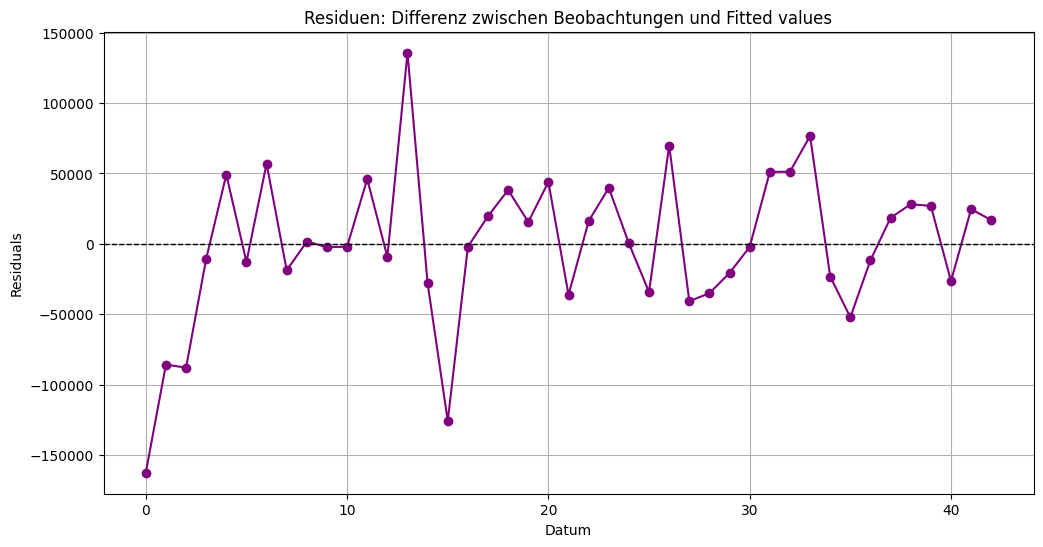

<Figure size 1200x600 with 0 Axes>

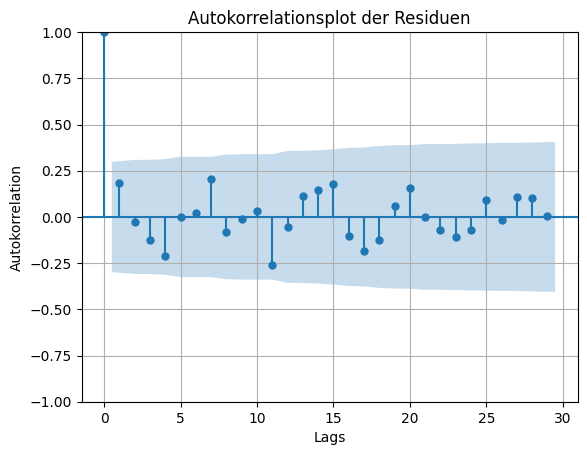

In [ ]:
errors = cv_df['error']

box_pierce_test(residuals = errors, store_num = store_number, lags = 29)
ljung_box_test(residuals = errors, store_num = store_number, lags = 29)
breusch_godfrey_test(model = sarima_model, lags = 29) #TODO: gleiches modell wie in-sample?
monti_test(residuals = errors, store_num = store_number, m = 21)
fisher_test(residuals = errors, store_num = store_number, m = 4)
run_test(residuals = errors)

durbin_watson_test(residuals = errors)

residual_plot(residuals = errors)
acf_resid_plot(residuals = errors)


Mittelwert Tests

Mittelwert der Errors: -77.7188777143114
T-Test: 0.9924
Wilcoxon Test: 0.7514
Binomial Test: 1.0000
Kolmogorov Test: 0.6411


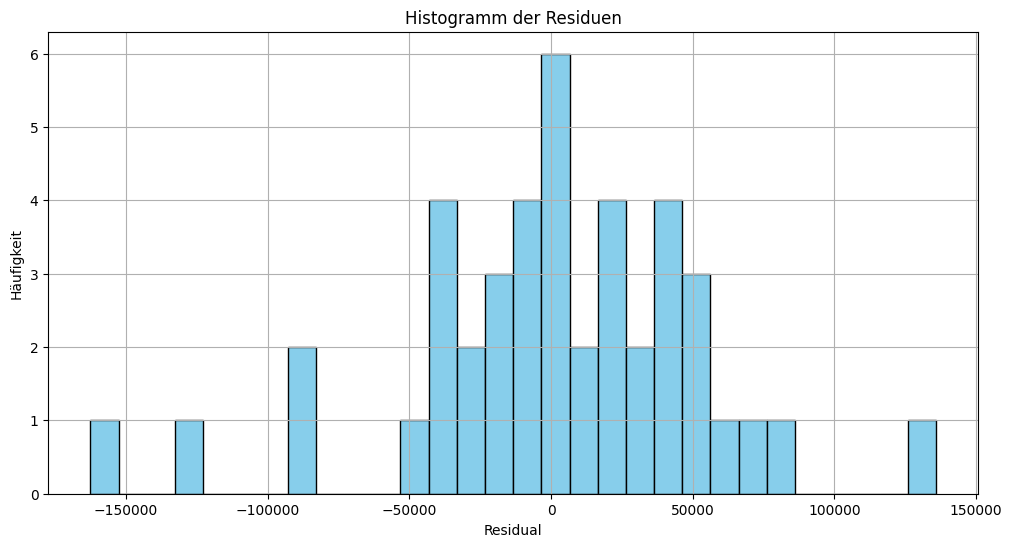

In [ ]:
#mean_errors = errors.mean()
print(f'Mittelwert der Errors: {errors.mean()}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)

hist_plot(errors)


SMAPE

In [ ]:
actual_values = cv_df['actual']
forecast_values = cv_df['forecast']

numerator = np.abs(forecast_values - actual_values)
denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 3.28%
